# Loading LSTM from training notebook

In [ ]:
import torch
import pickle

import sys
sys.path.append('../')  # Go up to src/ directory
from models import LSTM_model

model = LSTM_model(input_size=14)  # 14 features now (was 9)
model.load_state_dict(torch.load('lstm_model.pth'))
scaler_X, scaler_y = pickle.load(open('scalers.pkl', 'rb'))

ImportError: /home/marcus/.pyenv/versions/global_env/lib/python3.11/site-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkGetErrorLogSize_12_9, version libnvJitLink.so.12

# Evaluate and plot

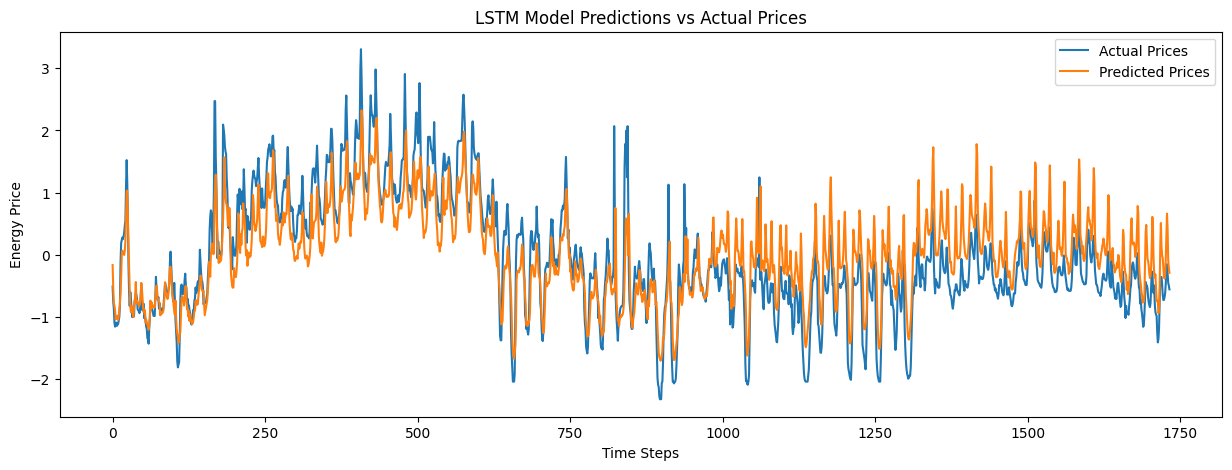

In [3]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

from dataset import EnergyPriceDataset, load_and_preprocess_energy_data

df = load_and_preprocess_energy_data('../../data/energy_data.csv')

feature_cols = [
    'Hour', 'day_nr', 'week_nr', 'year', 'month',
    'day_of_year_sin', 'day_of_year_cos',
    'wind_forecast_dah_mw', 'consumption_forecast_dah_mw',
    'temp_forecast_dah_celcius', 'temp_norm_celcius',
    'heating_demand_interaction', 'temp_deviation',
    'spot_lag1'
]
target_col = 'spot'

split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]

test_features = scaler_X.transform(test_df[feature_cols])
test_targets = scaler_y.transform(test_df[[target_col]])

sequence_length = 24 # 24 = one day, 168 = one week
test_dataset = EnergyPriceDataset(test_features, test_targets, sequence_length)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        predictions.extend(pred.squeeze().tolist())
        actuals.extend(y_batch.tolist())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Energy Price')
plt.show()

## OGD on the output

In [4]:
from OGD import OGD_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

ogd = OGD_Predictor(alpha=0.1, eta=1, q_init=50)

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [125.86, 225.66], pred=175.76, true=143.37, covered=True, q=49.90
t=100: [73.52, 155.32], pred=114.42, true=120.30, covered=True, q=40.90
t=200: [106.95, 208.75], pred=157.85, true=189.85, covered=True, q=50.90
t=300: [121.93, 251.73], pred=186.83, true=218.50, covered=True, q=64.90
t=400: [230.03, 379.83], pred=304.93, true=386.37, covered=False, q=74.90
t=500: [242.78, 394.58], pred=318.68, true=369.32, covered=True, q=75.90
t=600: [251.45, 407.25], pred=329.35, true=344.11, covered=True, q=77.90
t=700: [85.90, 229.70], pred=157.80, true=166.65, covered=True, q=71.90
t=800: [19.70, 143.50], pred=81.60, true=55.45, covered=True, q=61.90
t=900: [-30.07, 107.73], pred=38.83, true=-1.68, covered=True, q=68.90
t=1000: [155.88, 287.68], pred=221.78, true=181.26, covered=True, q=65.90
t=1100: [97.31, 239.11], pred=168.21, true=124.52, covered=True, q=70.90
t=1200: [177.11, 334.91], pred=256.01, true=167.05, covered=False, q=78.90
t=1300: [45.64, 215.44], pred=130.54, true=32.58, covere

# ECI on output

In [ ]:
from OGD import ECI_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

eci = ECI_Predictor(alpha=0.1, eta=5.0, q_init=10, c=1.0, version='basic', eq_function='sigmoid')

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = eci.get_interval(y_pred)
    covered = eci.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci.q
        threshold = eci.q
        
    if t % 100 == 0:
        lower, upper = eci.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci.q:.2f}")
print("\n ")
print(f"Coverage Rate: {eci.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {eci.q:.2f}")
print(f"Average Width: {np.mean(eci.threshold_history)*2:.2f}")

misses = sum(1 for c in eci.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci.coverage_history)}")

t=0: [79.14, 272.38], pred=175.76, true=143.37, covered=True, q=96.62
t=100: [105.13, 123.70], pred=114.42, true=120.30, covered=False, q=9.28
t=200: [118.28, 197.42], pred=157.85, true=189.85, covered=True, q=39.57
t=300: [144.73, 228.93], pred=186.83, true=218.50, covered=True, q=42.10
t=400: [243.03, 366.82], pred=304.93, true=386.37, covered=False, q=61.89
t=500: [263.49, 373.88], pred=318.68, true=369.32, covered=False, q=55.20
t=600: [282.12, 376.57], pred=329.35, true=344.11, covered=True, q=47.23
t=700: [101.58, 214.03], pred=157.80, true=166.65, covered=True, q=56.22
t=800: [54.51, 108.68], pred=81.60, true=55.45, covered=False, q=27.09
t=900: [-22.91, 100.57], pred=38.83, true=-1.68, covered=True, q=61.74
t=1000: [172.53, 271.03], pred=221.78, true=181.26, covered=True, q=49.25
t=1100: [104.39, 232.03], pred=168.21, true=124.52, covered=True, q=63.82
t=1200: [201.62, 310.39], pred=256.01, true=167.05, covered=False, q=54.39
t=1300: [58.54, 202.53], pred=130.54, true=32.58, co